


# XGBoost Algorithm



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import set_printoptions

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler

from imblearn.under_sampling import RandomUnderSampler, NearMiss, ClusterCentroids


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold

In [2]:
df_ppi_1 = pd.read_csv('data/base_cerevisiae.csv')
df_ppi_2 = pd.read_csv('data/base_elegans.csv')
df_ppi_3 = pd.read_csv('data/base_droso.csv')

In [3]:
df = pd.concat([df_ppi_1, df_ppi_2, df_ppi_3], ignore_index=True)
df

,Locus,Sequence,Sequence_Length,Aromaticity,Sec_Struct_Helix,Sec_Struct_Turn,Sec_Struct_Sheet,Percent_A,Percent_C,Percent_D,...,Percent_V,Percent_W,Percent_Y,Protein_key,DegreeCentrality,EigenvectorCentrality,BetweennessCentrality,ClosenessCentrality,Clustering,is_essential
0,YPL071C,MSSRFARSNGNPNHIRKRNHSPDPIGIDNYKRKRLIIDLENLSLND...,156,0.096154,0.288462,0.211538,0.185897,0.044872,0.006410,0.128205,...,0.038462,0.032051,0.038462,4932.YPL071C,0.000986,0.000512,3.315435e-06,0.426787,0.266667,0
1,YLL050C,MSRSGVAVADESLTAFNDLKLGKKYKFILFGLNDAKTEIVVKETST...,143,0.111888,0.307692,0.244755,0.237762,0.076923,0.006993,0.083916,...,0.083916,0.006993,0.048951,4932.YLL050C,0.053392,0.017135,2.003725e-04,0.497262,0.302355,1
2,YMR172W,MSGMGIAILCIVRTKIYRITISFDYSTLMSPFFLFLMMPTTLKDGY...,719,0.043115,0.219750,0.326843,0.214186,0.055633,0.002782,0.058414,...,0.030598,0.004172,0.018081,4932.YMR172W,0.007557,0.002314,3.144740e-06,0.438952,0.289855,0
3,YOR185C,MSAPAQNNAEVPTFKLVLVGDGGTGKTTFVKRHLTGEFEKKYIATI...,220,0.109091,0.318182,0.195455,0.236364,0.077273,0.013636,0.063636,...,0.081818,0.013636,0.040909,4932.YOR185C,0.046164,0.017683,1.040158e-04,0.491754,0.307905,0
4,YLL032C,MDNFKIYSTVITTAFLQVPHLYTTNRLWKPIEAPFLVEFLQKRISS...,825,0.100606,0.335758,0.244848,0.225455,0.042424,0.010909,0.042424,...,0.043636,0.002424,0.043636,4932.YLL032C,0.021028,0.006141,1.265410e-04,0.473128,0.236713,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30506,7227.FBpp0306211,MARLISGVRNLFHRYPFVTNSAIYGSLYVGAEYSQQFASKRWLATA...,204,0.147059,0.392157,0.196078,0.264706,0.102941,0.014706,0.029412,...,0.073529,0.029412,0.058824,7227.FBpp0306211,0.000177,0.000006,1.872049e-08,0.290879,0.000000,0
30507,7227.FBpp0306213,MVKILQAYNFARQQTYALNGDILAASLIGNNRIAISSAEQFIEIYD...,1536,0.083984,0.311198,0.236979,0.262370,0.074870,0.019531,0.052734,...,0.065104,0.005208,0.035807,7227.FBpp0306213,0.001237,0.000074,6.935191e-06,0.324301,0.648352,0
30508,7227.FBpp0306214,MSGGDYDSGDYFMRSRKQRDKPSLWDSFQDPPSKKTSGSDADWKKL...,1393,0.117014,0.366116,0.183058,0.289304,0.083274,0.022254,0.055994,...,0.071070,0.023690,0.035176,7227.FBpp0306214,0.014759,0.005067,1.719578e-04,0.421110,0.268595,0
30509,7227.FBpp0306223,MEREIAHSLAGGEERSSDVAPGQVKTFEELRLYRNLLNGLKRNNFV...,1028,0.071012,0.259728,0.250000,0.245136,0.057393,0.007782,0.052529,...,0.057393,0.003891,0.034047,7227.FBpp0306223,0.055590,0.016066,4.047679e-04,0.451477,0.227401,1


### Análise Exploratória

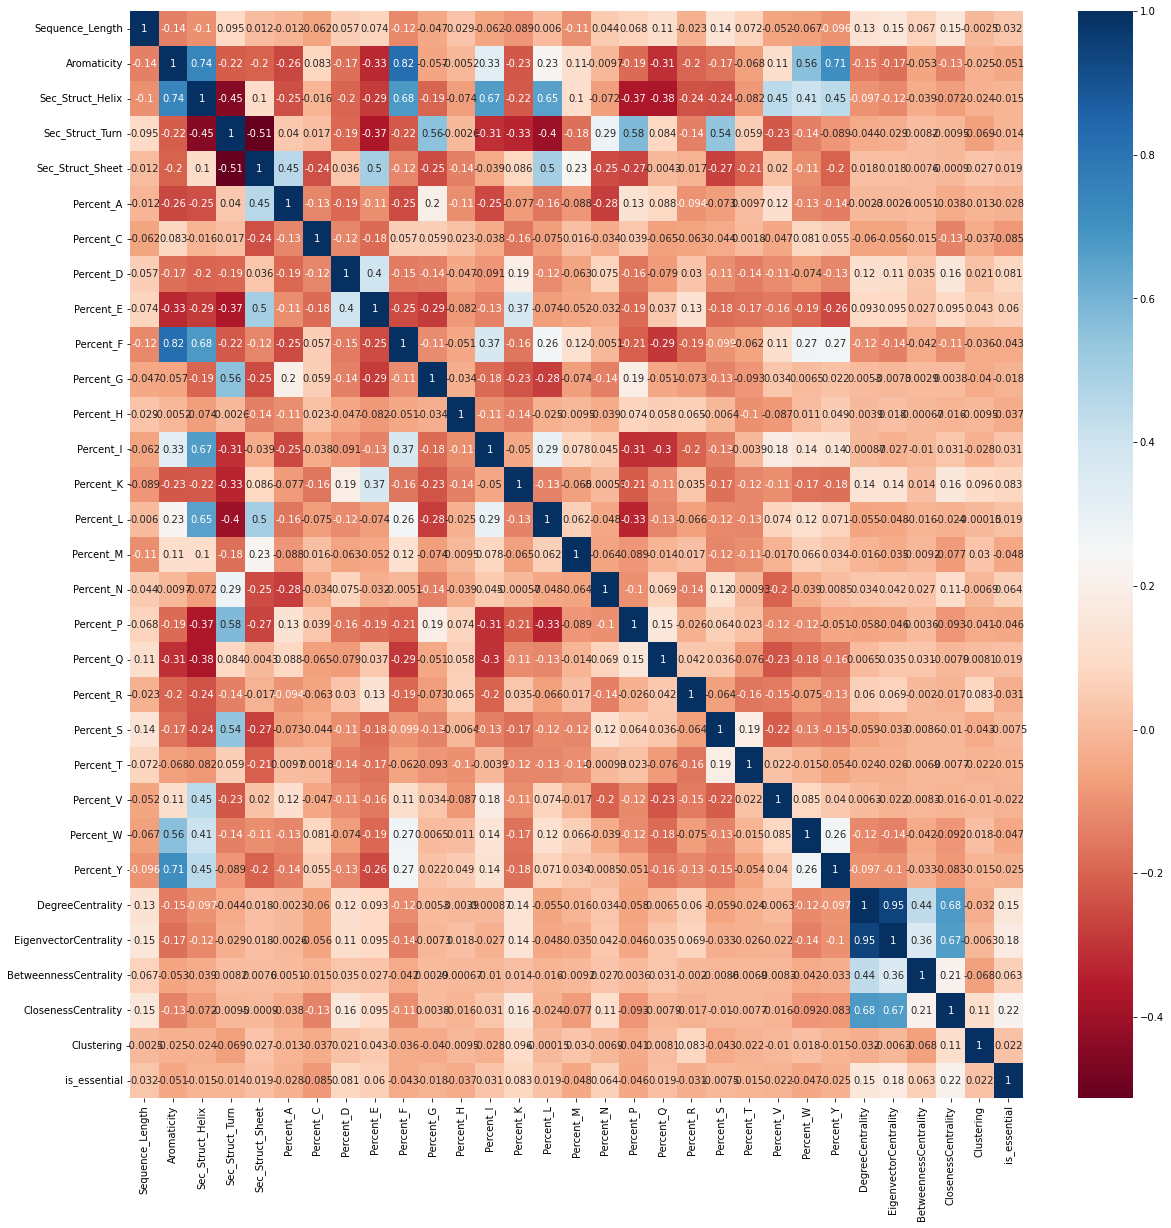

In [5]:
# Matriz de Correlação com Matplotlib Seaborn incluindo a classe de predição
sns.heatmap(df.corr(), annot=True, cmap='RdBu');

plt.rcParams["figure.figsize"] = (20,20)

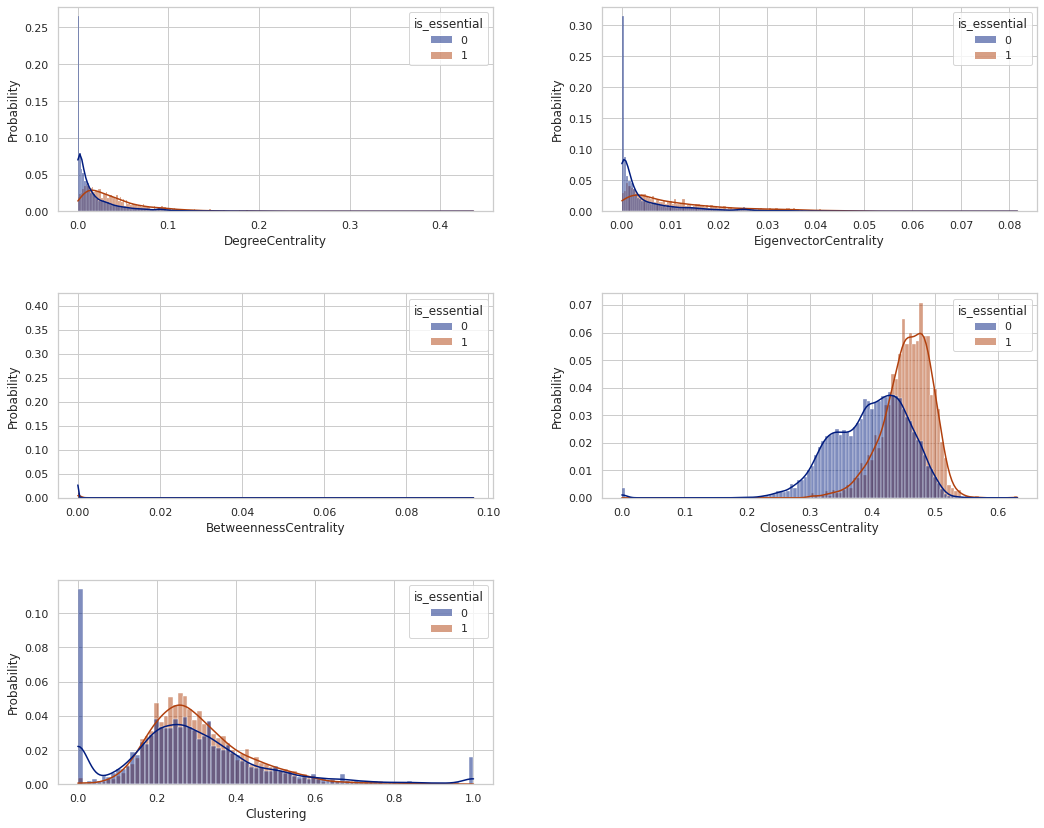

In [9]:
features = ['DegreeCentrality', 'EigenvectorCentrality', 'BetweennessCentrality',
       'ClosenessCentrality', 'Clustering']

plt.rcParams['figure.figsize'] = (16,12)

# Define as configurações dos plots
# Cada plot terá o mesmo tamanho de figuras (8,10)
#plt.style.use("ggplot")

plt.figure(1)

sns.set_theme(style="whitegrid", palette="dark")

plt.title('Distribuição dos dados - Baseadas em Sequência')

# Dados para cada subplot

for index, value in zip(range(1,6), features):
    plt.subplot(3, 2, index)
    sns.histplot(data=df, x=value, hue="is_essential", 
             stat="probability", common_norm=False, kde=True)

plt.subplots_adjust(top=0.95, bottom=0.05, left=0.10, right=0.95, hspace=0.4,
                    wspace=0.25)

plt.savefig("results_centrality.jpg")
plt.show()


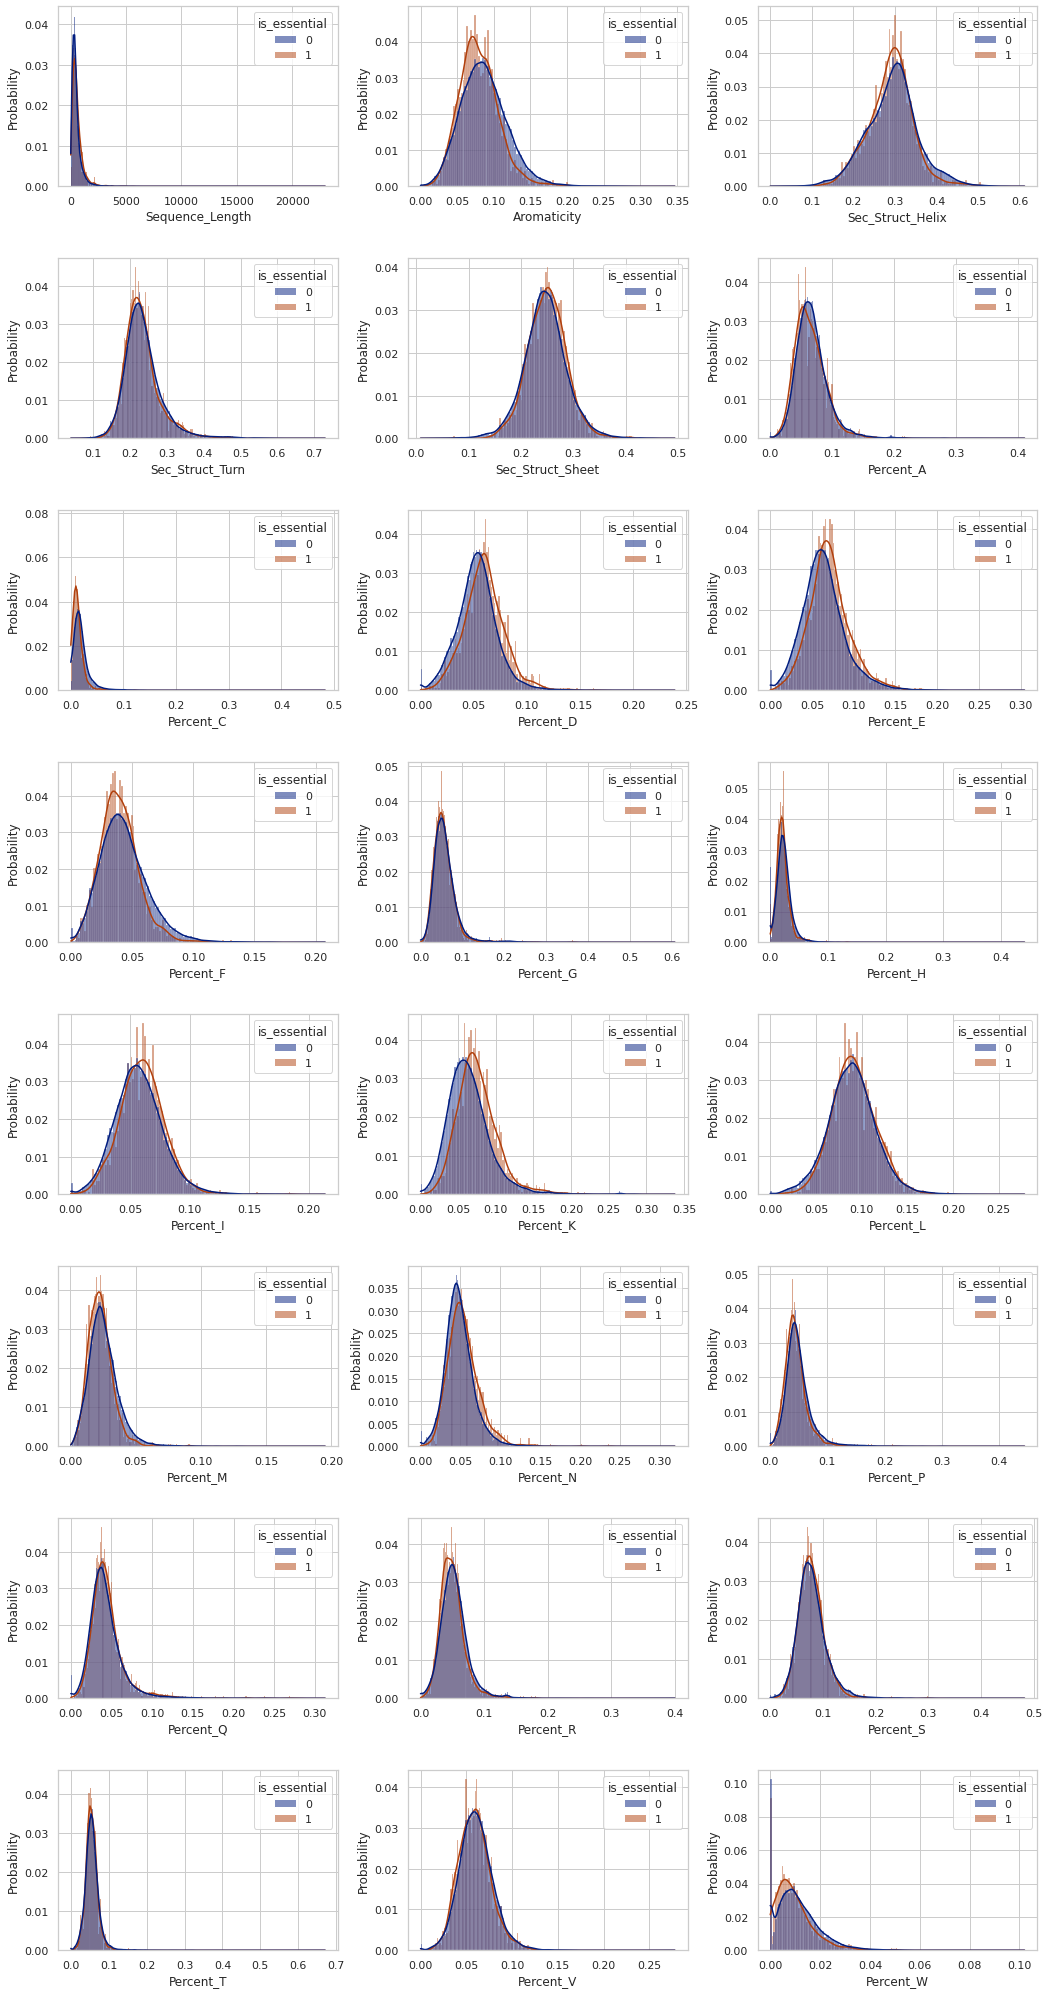

In [11]:
features_seq = ['Sequence_Length', 'Aromaticity', 'Sec_Struct_Helix',
       'Sec_Struct_Turn', 'Sec_Struct_Sheet', 'Percent_A', 'Percent_C',
       'Percent_D', 'Percent_E', 'Percent_F', 'Percent_G', 'Percent_H',
       'Percent_I', 'Percent_K', 'Percent_L', 'Percent_M', 'Percent_N',
       'Percent_P', 'Percent_Q', 'Percent_R', 'Percent_S', 'Percent_T',
       'Percent_V', 'Percent_W', 'Percent_Y']


plt.rcParams['figure.figsize'] = (16,30)

plt.figure(1)

sns.set_theme(style="whitegrid", palette="dark")

plt.title('Distribuição dos dados - Medidas de Centralidade e Clustering')

# Dados para cada subplot

for index, value in zip(range(1,25), features_seq):
    plt.subplot(8, 3, index)
    sns.histplot(data=df, x=value, hue="is_essential", 
             stat="probability", common_norm=False, kde=True)
    

plt.subplots_adjust(top=0.95, bottom=0.05, left=0.10, right=0.95, hspace=0.4,
                    wspace=0.25)

plt.savefig("results_sequence.jpg")
plt.show()

### Funções

In [12]:
# Função para validação cruzada sem o uso de balanceamento na amostra de validação

def validacao_cruzada(model, X, y, sampling = False, method_sampling = None):
    kfold = KFold(n_splits = 5, shuffle=True)
    
    acuracias_split = []
    
    for idx, (idx_treino, idx_validacao) in enumerate(kfold.split(X)):
        X_split_treino = X.iloc[idx_treino, :]
        y_split_treino = y.iloc[idx_treino, :]
        
        
        if sampling: 
            # Método de Sampling
            sm = method_sampling
            X_split_treino, y_split_treino = sm.fit_resample(X_split_treino, y_split_treino)
            
        model.fit(X_split_treino, y_split_treino.values.ravel())  
        
        X_split_validacao = X.iloc[idx_validacao, :]
        y_split_validacao = y.iloc[idx_validacao, :]
        
        
        pred_validacoes = model.predict(X_split_validacao)
        
        acuracia_split = accuracy_score(y_split_validacao, pred_validacoes)
        
        acuracias_split.append(acuracia_split)
        
        print(f'Acurácia do split {idx}: {acuracia_split}')
        
        mean = np.mean(acuracias_split)
        
    return print(f'Média de Acurácia na validação cruzada: {mean}')

## Pré-processamento de Dados

In [13]:
# Separação em conjuntos de treino e teste
X = df.drop(['Protein_key','is_essential', 'Locus', 'Sequence'], axis=1)
#X = df_select
y = df[['is_essential']]
test_size = 0.2
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, 
                                                    random_state=seed,
                                                    shuffle=True, 
                                                    stratify=y)

In [14]:
## Undersampling

undersample = RandomUnderSampler(random_state=seed)
#undersample = NearMiss()

X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

y_train_under.value_counts()

is_essential
0               1334
1               1334
dtype: int64

In [15]:
## Oversampling

oversample = SMOTE(random_state=seed)
#oversample = RandomOverSampler(random_state=seed)

X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

y_train_over.value_counts()

is_essential
0               23074
1               23074
dtype: int64

In [16]:
# define min max scaler
scaler = MinMaxScaler()
# transform data
scaled_train = scaler.fit_transform(X_train_over)
print(scaled_train)

[[3.11463968e-02 2.73023959e-01 5.17185386e-01 ... 1.28346551e-04
  5.79016717e-01 8.79120879e-02]
 [1.15163148e-02 9.97353959e-02 2.26066897e-01 ... 1.43923252e-04
  6.63972545e-01 3.02931202e-01]
 [6.89233991e-03 2.99260688e-01 5.08743169e-01 ... 1.07058868e-03
  6.80878703e-01 9.12050870e-02]
 ...
 [9.90228581e-03 2.50207925e-01 4.47030336e-01 ... 5.63495169e-03
  7.90450233e-01 3.12185578e-01]
 [5.75815739e-03 2.59660659e-01 4.53686983e-01 ... 4.24623409e-03
  7.79459598e-01 2.76932865e-01]
 [1.40464142e-02 2.71489795e-01 6.02252170e-01 ... 4.04788242e-03
  7.56423831e-01 1.96586120e-01]]


In [17]:
n_features = scaled_train.shape[1]
n_features

30

## Algoritmo XGBoost

In [28]:
xgbc = XGBClassifier(n_estimators=100, random_state=7)

# Training the XGB classifier
xgbc.fit(X_train_under, y_train_under)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=7,
              reg_alpha=0, reg_lambda=1, ...)

In [29]:
# Validação cruzada 
validacao_cruzada(xgbc, X_train, y_train, True, undersample)

Acurácia do split 0: 0.7240884883244572
Acurácia do split 1: 0.7232691519868906
Acurácia do split 2: 0.7298238426874232
Acurácia do split 3: 0.7141979102642901
Acurácia do split 4: 0.7516902274124155
Média de Acurácia na validação cruzada: 0.7286139241350953


In [30]:
y_pred = xgbc.predict(X_test)

In [31]:
# Scikit-learn
print(confusion_matrix(y_test, y_pred))

[[4225 1544]
 [  77  257]]


In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84      5769
           1       0.14      0.77      0.24       334

    accuracy                           0.73      6103
   macro avg       0.56      0.75      0.54      6103
weighted avg       0.94      0.73      0.81      6103



### Algoritmo Random Forest

In [33]:
rfc = RandomForestClassifier().fit(X_train_under, y_train_under)

/tmp/ipykernel_7054/613288721.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc = RandomForestClassifier().fit(X_train_under, y_train_under)


In [34]:
# Validação cruzada 
validacao_cruzada(rfc, X_train, y_train, True, undersample)

Acurácia do split 0: 0.7283900040966816
Acurácia do split 1: 0.6999180663662433
Acurácia do split 2: 0.6775911511675543
Acurácia do split 3: 0.7127637779143619
Acurácia do split 4: 0.7297684900635115
Média de Acurácia na validação cruzada: 0.7096862979216706


In [35]:
y_pred = rfc.predict(X_test)

In [36]:
# Scikit-learn
print(confusion_matrix(y_test, y_pred))

[[4129 1640]
 [  62  272]]


In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.72      0.83      5769
           1       0.14      0.81      0.24       334

    accuracy                           0.72      6103
   macro avg       0.56      0.77      0.54      6103
weighted avg       0.94      0.72      0.80      6103

